In [1]:
using PyPlot

INFO: Recompiling stale cache file /Users/ortner/.julia/lib/v0.4/PyPlot.ji for module PyPlot.


# Finite Difference Laplace Solver

by [Christoph Ortner](http://homepages.warwick.ac.uk/staff/C.Ortner/)  
last update 11 May 2016
tested ok on Julia 0.4.5

We will solve the Laplace equation
$$\begin{align*}
 - \Delta u &= 1, \quad  x \in \Omega \\
  u &= 0, \quad x \in \partial \Omega.
\end{align*}$$

using the standard 5-point finite difference scheme.  This notebook is inspired by a [Matlab tutorial](http://uk.mathworks.com/examples/matlab/1091-finite-difference-laplacian). It is intended as a rapid introduction to Julia for numerical analysts, primarily if coming from Matlab.


## 1. The Mesh

Julia does not have an automatic mesh generator implemented (such as `numgrid`), so we will do this from scratch. For simplicity, we just implement the L-shape, but generalisations are straightforward. We first generate an $(N+1) \times (N+1)$ grid of zeros, then "paint" all grid points with ones that will be free. The remaining zero points will enforce the Dirichlet condition. 


In [4]:
function lshape(N)
    # make sure N is even
    N = round(Int, N/2) * 2
    # create a zero-array (the `Int` tells Julia to make it integers)
    L = zeros(Int, N+2, N+2)
    # fill in the "domain" with ones
    # note the ÷ : this is integer division 
    #    (Julia does not like indexing with non-integers)
    L[2:N ÷ 2+1,2:N+1] = 1
    L[2:N+1,N ÷ 2+2:N+1] = 1
    # return the completed array
    return L
end

# generate a mesh for demonstration
L = lshape(9)
println(L)


[0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0]


## 2. The Laplace Operator

Julia also does not have a finite difference laplacian (`delsq` in Matlab) implemented (probably deemed too specific by the Julia developers), so we need to do it again ourselves. One could translate the Matlab code almost verbatim, but then we would run into copyright issues. Here is an alternative code which is in fact briefer and faster.

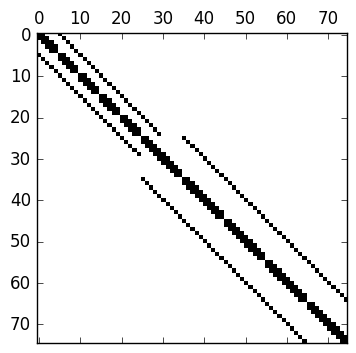

In [6]:
function fdlaplacian(G)
    # read info about G
    M, N = size(G)
    nonz = find(G)
    # define function to create a 1D laplacian and a sparse identity
    fdl1(m) = spdiagm((ones(m-1),-2*ones(m),ones(m-1)), [-1,0,1])
    # laplace operator on the full grid
    A = kron(speye(M), fdl1(N)) + kron(fdl1(M), speye(N))
    # return the restriction to the coloured grid points
    return A[nonz, nonz]
end

# do a spy plot of the laplacian matrix
# the `figsize` property adjusts the size of the figure
figure(figsize=[4,4])
spy(fdlaplacian(lshape(10)))

# the `;` ensures that we don't get a weird output 
# at the end of the cell that we don't want
;

### Solving the PDE

We are now ready to solve the finite difference equation. Luckily Julia *does* have a sparse linear solver implemented, it is an interface to [UMFPack](http://faculty.cse.tamu.edu/davis/suitesparse.html) (same as Matlab).

In [7]:
# assemble the right-hand side
N = 60
L = lshape(N)
A = - fdlaplacian(L)
b = ones(size(A,1)) / N^2
# solve the linear system > this uses UMFPACK (same as Matlab)
# the ; supresses output
u = A \ b;

## 3. Basic Plotting

Julia does not (yet) have plotting functionality comparable to Matlab implemented natively, but a number of packages are under development. At the moment the packages [Gadfly](http://dcjones.github.io/Gadfly.jl/), [Plotly](https://plot.ly/julia/) and [PyPlot](https://github.com/stevengj/PyPlot.jl) seem to be useful. Also look at [Plots](https://github.com/tbreloff/Plots.jl) which provides a unified interface to difference packages.

Here, we will use [PyPlot](https://github.com/stevengj/PyPlot.jl), an interface to Python's [matplotlib package](http://matplotlib.org), which is designed to behave very much like Matlab (some functionality is missing, while some is more advanced).

### Contour plot

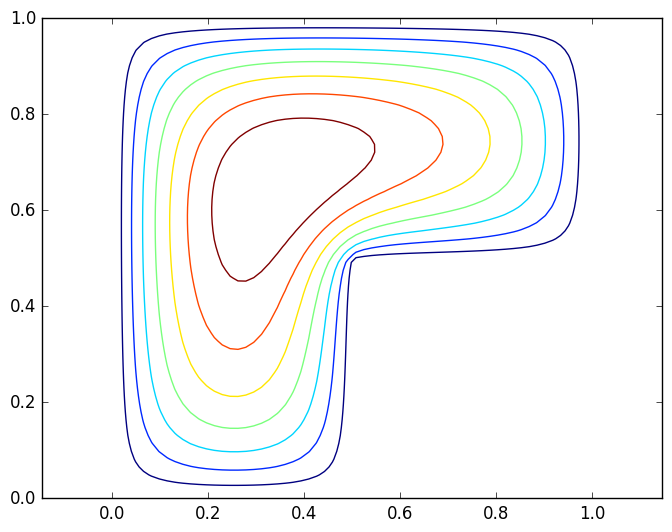

In [9]:
# create the grid on which we are solving the FD equantion
#             (why does Julia not implement meshgrid?!?!)
X = (linspace(0, 1, N+2) * ones(1, N+2)); Y = X'
# write solution into plottable format
U = zeros(size(L))
U[find(L)] = u
# call the correct PyPlot routine
contour(X, Y, U)
axis("equal"); 

### Surface Plot

We make this one a little bit nicer, to get it closer to publication quality. It needs just a little more fiddling than in Matlab. For example, `surf` has strange default options that we need to overwrite to see anything useful. A very nice feature is that Latex labels are fully supported. SVG export is also useful for postprocessing in another software.

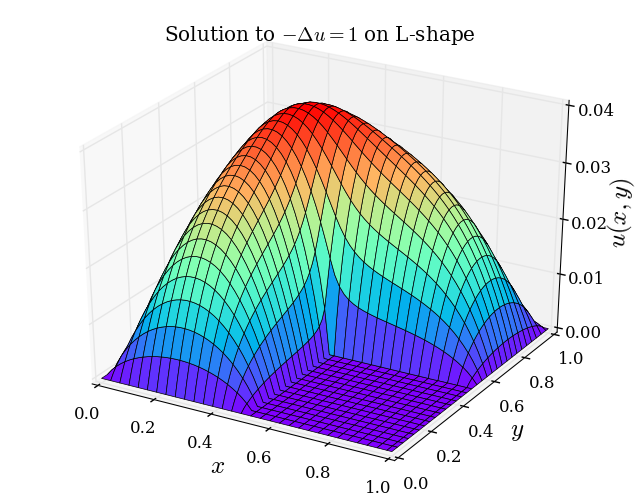

In [12]:
# the next line makes the standard font serif, to match
# the standard Latex fonts in publications
PyPlot.rc("font", family="serif")
# set the following line to true if you want the plot in a separate interactive window
pygui(false)
# plot the wireframe mesh
surf(X, Y, U, rstride=2, cstride=2, 
      cmap=ColorMap("rainbow"), linewidth=0.5)
# some latex labels
title(L"Solution to $-\Delta u = 1$ on L-shape")
xlabel(L"$x$", fontsize=18); 
ylabel(L"$y$", fontsize=18); 
zlabel(L"$u(x,y)$", fontsize=18)
# some axis formatting
xticks([0,.2,.4,.6,.8,1])
yticks([0,.2,.4,.6,.8,1])
zticks([0,.01,.02,.03,.04])
# setting svg -> true gives better quality plot 
# (also makes the notebook slower, so only use for final version.)
# then uncomment the `savefig` line to save the resulting figure
PyPlot.svg(false);
# savefig("plot.svg");

## 4. Eigenvalue Solver

While we are at it, it would be fun to also compute some eigenvalues and eigenfunctions,
$$
  - \Delta v_j = \lambda_j v_j.
$$
This is achieved using the `eigs` command. To plot several of them, we can practise the `subplot` command.

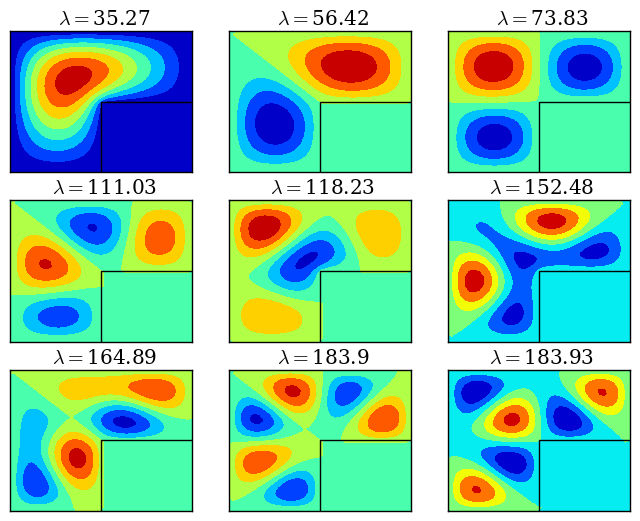

In [14]:
##### assemble the laplacian
N = 40
L = lshape(N)
X = (linspace(0, 1, N+2) * ones(1, N+2)); Y = X'
A = - fdlaplacian(L)*N^2

# get the first 9 eigenvalues
# Note that `:SM` is a Symbol (see Julia docs)
lam, v, = eigs(A; nev=9, which=:SM, tol=0.0, maxiter=1000, ritzvec=true)

# plot the results
for i = 1:9
    subplot(3,3,i)
    V = zeros(size(X))
    V[find(L)] = v[:, i]
    contourf(X, Y, V)
    plot([.5,.5,1], [0,.5,.5], "k-")
    title(string(L" $\lambda = $", round(lam[i], 2)))
    xticks([]); yticks([]); axis("equal");
end
